<a href="https://colab.research.google.com/github/shantam-8/ML-Materials-Individual-Project/blob/main/Individual_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Project

In [1]:
# import numpy as np

# # Insert your values
# Name = "Shantam Gilra" # Replace with your name
# CID = 1878023 # Replace with your College ID (as a numeric value with no leading 0s)

# # Set a random seed using the CID value
# CID = int(CID)
# np.random.seed(CID)

# # Print the message
# print("This is the work of " + Name + " [CID: " + str(CID) + "]")

## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark.

# Libraries Used

In [1]:
training_mode = True

In [2]:
# Installation of libraries
if training_mode == False:
  !pip install matminer=="0.9.0" --quiet
  !pip install pymatgen=="2023.09.25" --quiet
!pip install elementembeddings --quiet

!pip install xgboost --quiet
!pip install lightgbm --quiet

In [4]:
# !pip install CBFV --user

# !pip install -U xenonpy

# !pip install parallel-pandas --user



In [3]:
# Import of modules
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation with DataFrames


if training_mode == False:
  import matminer  # Materials informatics
  from matminer.datasets.dataset_retrieval import load_dataset  # Load materials datasets
  from pymatgen.core import Structure, Composition  # Materials analysis for crystal structures
from elementembeddings.core import Embedding


import plotly.express as px


# To make the model run faster
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation



In [4]:
if training_mode == False:
  df = load_dataset("matbench_expt_gap")
else:
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Main Data.csv")

df.head(10)

,composition,gap expt
0,Ag(AuS)2,0.00
1,Ag(W3Br7)2,0.00
2,Ag0.5Ge1Pb1.75S4,1.83
3,Ag0.5Ge1Pb1.75Se4,1.51
4,Ag2BBr,0.00
5,Ag2BiO3,0.00
6,Ag2GeS3,1.98
7,Ag2GeSe3,0.90
8,Ag2HgI4,2.47
9,Ag2Mo(I2O7)2,3.06


In order to correctly featurise the dataset given, different featurisers from Maminer and Element Embeddings were used. It was likely that different statistical elements (minimum, maximum, range, mean, avg_dev and mode) of different Magpie properties would be important to accurately predict the band gap. Hence, all statistical elements of all Magpie properties were added to the featurised dataset. This was followed by an addition to one-hot encoded columns of atomic structure and properties like the band center.

## Data Featurisation

In [5]:
if training_mode == False:

  # Featurising df
  from elementembeddings.composition import composition_featuriser, CompositionalEmbedding
  from matminer.featurizers.composition.composite import ElementProperty
  from matminer.featurizers.composition.element import BandCenter


  # Adding fractional composition column to main database.
  df['fractional_composition'] = df['composition'].apply(lambda x: Composition(x).fractional_composition)

  # Featurising based on magpie data using fractional composition.
  df_featurised = ElementProperty.from_preset(preset_name="magpie").featurize_dataframe(df, col_id='fractional_composition')

  # Featurising by adding one-hot collumns of each compound
  composition_df = composition_featuriser(df_featurised["composition"], embedding="atomic", stats=["sum"])
  df_featurised = pd.concat([df_featurised, composition_df], axis=1)

  # Featurising by adding one-hot collumns of each compound
  bandcenter_df = BandCenter().featurize_dataframe(df, col_id='fractional_composition', ignore_errors=True)
  df_featurised = pd.concat([df_featurised, bandcenter_df], axis=1)

  # Adding column that includes number of atoms in each compound
  df_featurised["num_atoms"] = df["composition"].apply(lambda x: CompositionalEmbedding(x, "magpie").num_atoms)

  # Drop non-featurised columns
  df_featurised = df_featurised.drop(["composition", "gap expt", "fractional_composition"], axis=1)

  # Drop duplicate columns
  df_featurised = df_featurised.T.drop_duplicates().T

else:
  df_featurised = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Featurised Data.csv")



df_featurised

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,sum_Pt,sum_Au,sum_Hg,sum_Tl,sum_Pb,sum_Bi,sum_Th,sum_U,band center,num_atoms
0,16.0,79.0,63.0,47.400000,25.280000,16.0,65.0,88.0,23.0,74.600000,...,0.0,2.0,0.0,0.0,0.00,0.0,0.0,0.0,5.640081,5.00
1,35.0,74.0,39.0,46.714286,15.619048,35.0,51.0,95.0,44.0,81.000000,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,6.330247,21.00
2,16.0,82.0,66.0,36.275862,23.552913,16.0,65.0,88.0,23.0,83.482759,...,0.0,0.0,0.0,0.0,1.75,0.0,0.0,0.0,5.198208,7.25
3,32.0,82.0,50.0,46.206897,17.388823,34.0,65.0,89.0,24.0,84.034483,...,0.0,0.0,0.0,0.0,1.75,0.0,0.0,0.0,5.044300,7.25
4,5.0,47.0,42.0,33.500000,14.250000,47.0,65.0,95.0,30.0,74.250000,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,5.032223,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,7.0,73.0,66.0,26.800000,23.760000,7.0,44.0,82.0,38.0,67.600000,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,5.627749,5.00
4600,40.0,52.0,12.0,46.000000,6.000000,40.0,44.0,90.0,46.0,67.000000,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,4.402714,2.00
4601,8.0,40.0,32.0,23.000000,8.500000,22.0,43.0,87.0,44.0,54.250000,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,4.221115,4.00
4602,9.0,40.0,31.0,14.500000,8.250000,9.0,43.0,93.0,50.0,80.625000,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,7.923077,8.00


It was not clear as to which features are important and training models with non-important features would increase computation costs and would decrease the model's accuracy. Hence, a preliminary Random Forest regressor was trained on the whole dataset to derive the feature importances of all features. This was represented in two different ways - a bar chart containing the feature importances of different features and a plot of one decision tree of the random forest ensemble.

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Define the features we want in the DataFrame
feature_cols = [col for col in list(df_featurised.columns) if col != "formula"]

# Get an array of the features
prelim_X = df_featurised[feature_cols]

# Get an array of the target variable
y = df["gap expt"]

# Training a preliminary random forest regressor to understand the importance of different features
prelim_rf = RandomForestRegressor()
prelim_rf.fit(prelim_X, y)

RandomForestRegressor()

In [7]:
# Load the atomic data
atomic_feature_labels = Embedding.load_data('atomic').feature_labels
one_hot_columns = ["sum_" + a for a in atomic_feature_labels]

# Get index of all one-hot encoded element columns to sum their feature importances
imp = prelim_rf.feature_importances_
feature_col = prelim_X.columns

elem_indices = [np.where(np.isin(prelim_X.columns, one_hot_columns))[0]]
elem_imp = imp[np.where(np.isin(prelim_X.columns, one_hot_columns))[0]].sum()

# Removing individual element contributions and adding them together
imp = np.delete(imp, elem_indices)
imp = np.append(imp, elem_imp)

# Removing individual element columns and adding "Elements"
feature_col = np.delete(feature_col, elem_indices)
feature_col = np.append(feature_col, "Elements")

# Sorting both arrays based on descending order of importances
sort_inds = imp.argsort()
imp = imp[sort_inds[::-1]]
feature_col = feature_col[sort_inds[::-1]]

# Plot the bar chart containing the feature importances of different features
fig = px.bar(x = feature_col, y = imp,
             labels={"x": "Preliminary Feature Columns", "y": "Feature Importances"},
             title="Feature Importance Bar Chart")

fig.update_xaxes(tickfont=dict(size = 7.5))
fig.show()

The chart signifies the importance of added features like the one-hot encoded atomic data and band center. However, as the band center values could not be derived for "Th" and "U" based compositions, compositions containing those elements were removed from the training and testing datasets. Furthermore, all features after "MagpieData range GSmagmom" have very less importance values (<0.001). Hence, these features were removed as well.

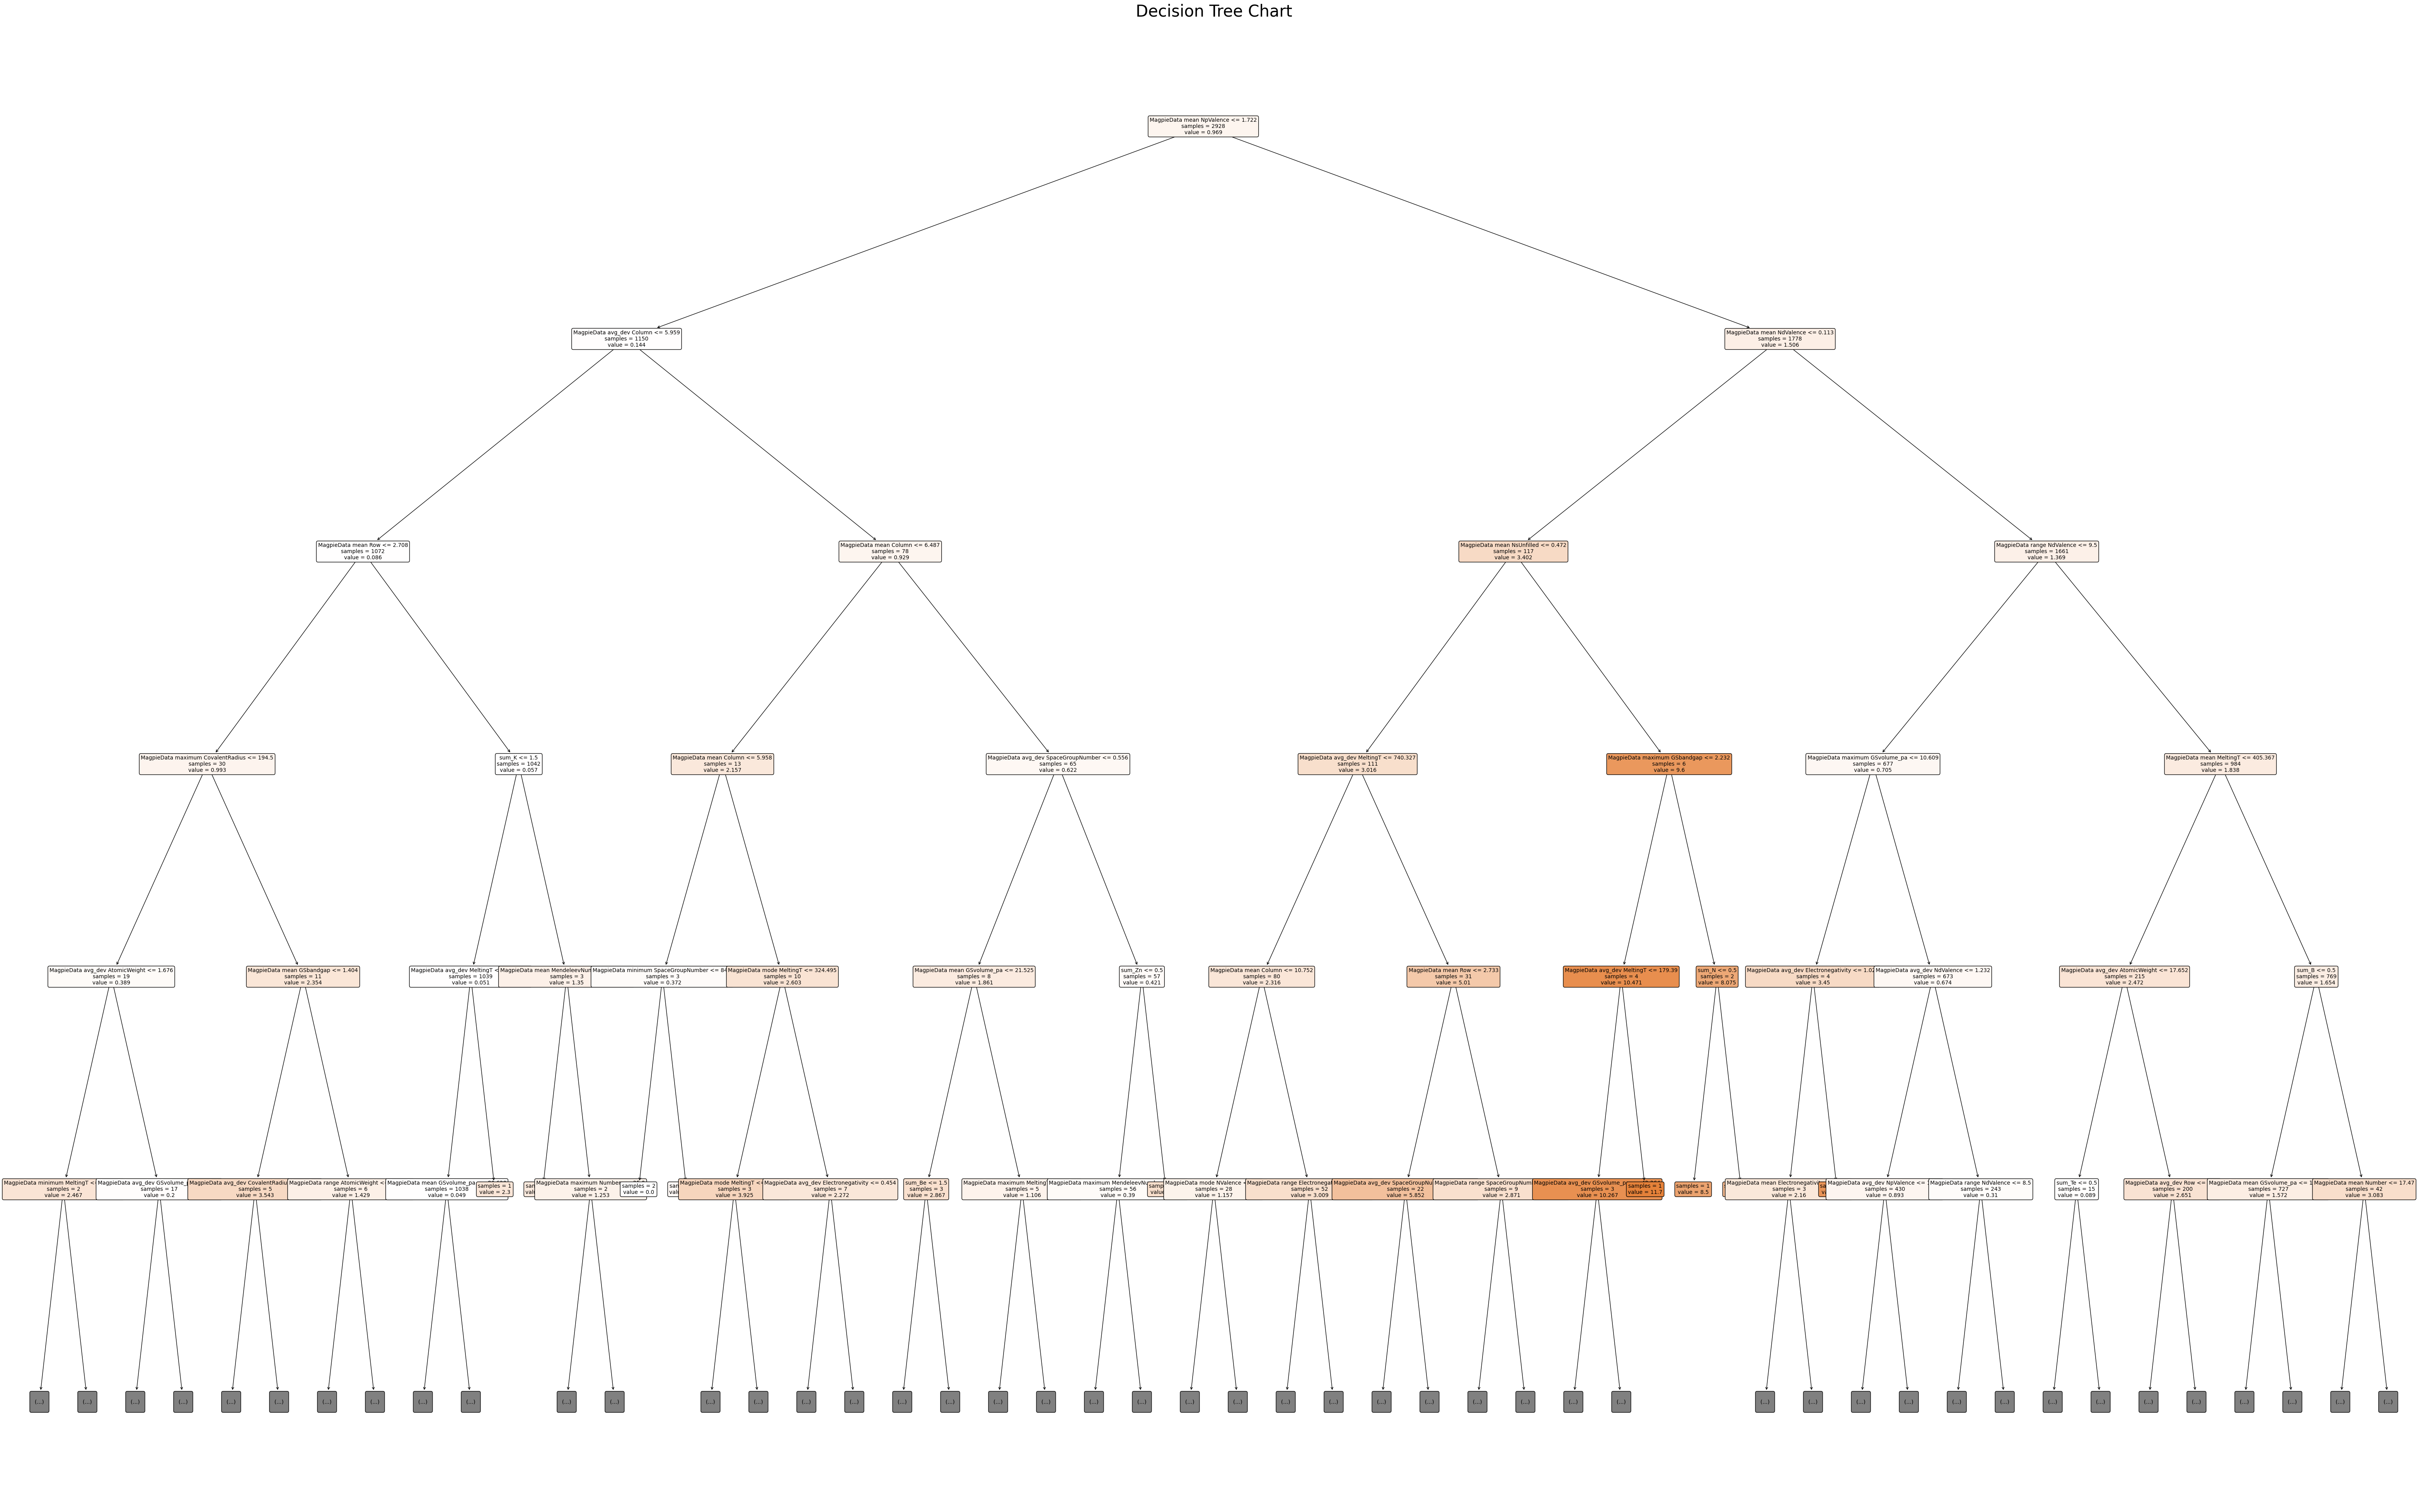

In [10]:
from sklearn import tree
import matplotlib.pyplot as plt

# Plot a chart of one decision tree in the random forest ensemble (click on the graph to zoom it)
plt.figure(figsize=(80, 50))
_ = tree.plot_tree(prelim_rf.estimators_[0], max_depth = 5, feature_names = df_featurised.columns, filled = True, rounded = True, fontsize = 10, impurity = False)
plt.title("Decision Tree Chart", fontsize = 30)
plt.show()

While the chart further amplified the importance of "MagpieData mean NpValence", it also showed the high extremity (darker shades of the box depict higher extremity) of compositions specific properties. This indicates that the predicted values of some compositions would have high deviations from the actual values.

While these compositions could be filtered out of the training and testing datasets, these were still left in the dataset as it can be possible that other decision trees in the ensemble or other models can accurately predict the band gap.

In [9]:
# Remove all column values in the featurised dataset with a lower feature importance than "MagpieData range GSmagmom"
X = df_featurised.drop(feature_col[np.where(feature_col == "MagpieData range GSmagmom")[0][0] + 1:], axis=1)

# Remove all NaN values. Maintaining the index to easily determine the actual composition in the raw dataset "df".
X = X.dropna()

The final dataset has 4480 compositions after removing 124 compositions from the main dataset.

## Data Analysis

The distribution of band gap values was then explored in the context of the features by reducing the number of dimensions to three using PCA.

In [12]:
from sklearn.decomposition import PCA

# Performing a 3 axes PCA on the featurised dataset
pca = PCA(n_components=3)
transformed_data = pca.fit_transform(X)

# Plotting 3D scatter plot
fig = px.scatter_3d (x = transformed_data[:, 0], y = transformed_data[:, 1], z = transformed_data[:, 2], color = df["gap expt"][X.index],
                     labels = {"x": "PCA X-axis", "y": "PCA Y-axis", "z": "PCA Z-axis", "color": "Band Gap"},
                     title = "PCA 3D Scatter Plot")

fig.update_layout(scene_camera = dict(eye = dict(x=0, y=0, z=1.5)))
fig.show()

The 3D Scatter plot is displayed on a specific camera angle to depict the relative postion of compositions having high and low band gaps - as seen, high band gaps are typically form a cluster in the left region. While the PCA did not have any information regarding the band gap, it was able to loosely seperate the high and low band gap compounds - hence, justifying the validity of the featurised dataset.

However, the 3D scatter plot also indicates the dominance of compositions with a low band gap. This distribution is further explored using a histogram.

In [13]:
# Plotting histogram of Band Gaps
fig = px.histogram(x = df["gap expt"][X.index],
                   nbins = 12,
                   marginal = "box",
                   labels = {"x": "Band Gap"},
                   title = "Distribution of Band Gaps")

fig.show()

Due to the comparatively high number of low band gaps as seen by the box plot and graph, the training and testing datasets can be split using a stratified split rather than a random split. This may ensure that the model will be more robust and accurate. However, to create preliminary models, a random split will be used.

# Training and Testing

## Models Evaluation

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Standard scaling of featurised dataset for different models.
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Target Values
y = df["gap expt"][X.index]

# Splitting train and test values
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.4, random_state=42)

In [4]:
def models_eval (models_dict, cv = 5, show_graph = False, cols = 3):

  # Setting up DataFrame object to hold data
  metrics_df = pd.DataFrame(columns = ["Model Name","CV RMSE (eV)", "CV R2", "Test RMSE (eV)", "Test R2", "Time (s)"])

  # Initiating figure if show_graph = True
  if show_graph:
    cols = cols
    rows = len(models_dict) // cols + (1 if len(models_dict) % cols != 0 else 0)

    fig = make_subplots(rows = rows,
                      cols = cols,
                      subplot_titles = list(models_dict.keys()))

  # Loop to run different models
  for ind, m in enumerate(models_dict):

    model = models_dict[m][0]
    X_train = models_dict[m][1]
    X_test = models_dict[m][2]
    y_train = models_dict[m][3]
    y_test = models_dict[m][4]

    model.fit(X_train, y_train)

    cv_scores = cross_validate(model, X_train, y_train, cv = cv, scoring = ('r2', 'neg_mean_squared_error'), n_jobs = -1)
    y_pred = model.predict(X_test)

    # Testing Metrics
    test_mse = np.sqrt(mean_absolute_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    metrics_list = [m,
                    np.sqrt(np.mean(abs(cv_scores["test_neg_mean_squared_error"]))),
                    np.mean(abs(cv_scores["test_r2"])),
                    test_mse,
                    test_r2,
                    np.mean(cv_scores["fit_time"])]

    # Storing metrics in metrics_df
    metrics_df.loc[len(metrics_df)] = metrics_list

    # Displaying graph if show_graph = True
    if show_graph:
      fig.add_trace(
          go.Scatter(x = y_test, y = model.predict(X_test), mode="markers"),
          col = ind % cols + 1,
          row = int(str((ind/cols) + 1)[0]),
          )

      fig.add_trace(
        go.Scatter(x = y_test, y = y_test, mode = "lines", line = dict(color = "black"), hoverinfo = "none"),
        col = ind % cols + 1,
        row = int(str((ind/cols) + 1)[0])
        )

      fig.update_xaxes(title_text="Actual Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))
      fig.update_yaxes(title_text="Predicted Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))


  if show_graph:
    fig.update_layout(height = 500 * rows, width = 500 * cols, showlegend = False, title_text="Model Evaluation")
    fig.show()

  return metrics_df

In [16]:
models_dict = {
    "Random Forest Regressor" : [RandomForestRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "Support Vector Machine Regressor" : [SVR(), X_train, X_test, y_train, y_test],
    "XG Boost" : [xg.XGBRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "Kernal Ridge" : [KernelRidge(), X_train, X_test, y_train, y_test],
    "KNN Regressor" : [KNeighborsRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "LGBM Regressor" : [LGBMRegressor(n_jobs = -1, verbose = -1), X_train, X_test, y_train, y_test],
    "Gradient Boost Regressor" : [GradientBoostingRegressor(), X_train, X_test, y_train, y_test]
}

models_eval(models_dict, show_graph = True)

,Model Name,CV RMSE (eV),CV R2,Test RMSE (eV),Test R2,Time (s)
0,Random Forest Regressor,0.866026,0.652725,0.676349,0.653690,18.556421
1,Support Vector Machine Regressor,1.037402,0.506467,0.729970,0.547736,0.664684
2,XG Boost,0.866999,0.652316,0.675580,0.666347,3.238517
3,Kernal Ridge,27.722871,327.813248,1.098217,-0.195286,0.415801
4,KNN Regressor,1.032767,0.508788,0.744461,0.535677,0.003622
5,LGBM Regressor,0.841495,0.673440,0.671174,0.655426,5.130618
6,Gradient Boost Regressor,0.910735,0.614688,0.734666,0.617833,6.149583


As seen by the above graphs and table, architecture of linear regression models like Kernal Ridge would not be suitable. Furthermore, the graphs indicate that all models are not able to predict Band Gap energy when its too high. This might be becuase there is not enough high Band Gap materials in the training set. In order to ensure this, a stratified split will be explored and compared with the normal split.

## Data Sratification

In [17]:
from sklearn.cluster import KMeans

kmean_cluster = KMeans(n_clusters = 3).fit(pd.DataFrame(y))

# Splitting train and test values
strat_X_train, strat_X_test, strat_y_train, strat_y_test = train_test_split(scaled_X, y, test_size = 0.4, stratify = kmean_cluster.labels_)

In [18]:
models_dict = {
    "Random Forest Regressor" : [RandomForestRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "Random Forest Regressor w Stratified" : [RandomForestRegressor(n_jobs = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
    "LGBM Regressor" : [LGBMRegressor(n_jobs = -1, verbose = -1), X_train, X_test, y_train, y_test],
    "LGBM Regressor w Stratified" : [LGBMRegressor(n_jobs = -1, verbose = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
    "Gradient Boost Regressor" : [GradientBoostingRegressor(), X_train, X_test, y_train, y_test],
    "Gradient Boost Regressor w Stratified" : [GradientBoostingRegressor(), strat_X_train, strat_X_test, strat_y_train, strat_y_test]
    }

models_eval(models_dict, cv = 2, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,Test RMSE (eV),Test R2,Time (s)
0,Random Forest Regressor,0.937288,0.595160,0.679863,0.646230,11.892612
1,Random Forest Regressor w Stratified,0.933739,0.599782,0.677750,0.649914,10.434081
2,LGBM Regressor,0.932098,0.599969,0.671174,0.655426,5.047656
3,LGBM Regressor w Stratified,0.944073,0.590838,0.671701,0.667520,3.135527
4,Gradient Boost Regressor,0.961147,0.574334,0.735698,0.616710,3.903423
5,Gradient Boost Regressor w Stratified,0.948451,0.587148,0.734199,0.626996,4.776080


As seen by the above analysis, stratification does not increase the accuracy of the model considerably. Hence, this will not be used moving forward.

## Hyperparameter Tuning

The above models would be hypertuned and then compared against each other.

## Trial Hypertuning

In [ ]:
!pip install hyperopt

In [12]:
from sklearn.model_selection import cross_val_score
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, STATUS_FAIL, space_eval

In [13]:
from sklearn.metrics import mean_squared_error

In [ ]:
# Defining Objective function whose loss we have to minimize
def objective(args):
  model = args["model"].set_params(**args["params"])
  print(model)

  model.fit(X_train, y_train)
  # pred = model.predict (X_test)
  # score = mean_squared_error (y_test, pred)

  score = (cross_val_score(model, X_train, y_train, cv = 2, n_jobs=-1)).mean()
  return {'loss': -score, 'status': STATUS_OK}


# Defining Search Space
svr_space = {
    'model':SVR(),
    'params':{
        'C': hp.uniform('C', 100, 2000),
        'epsilon': hp.uniform('epsilon', 0.000000001, 0.1),
    }
    }


# Putting it together
trials = Trials()

best_regressor = fmin(objective, svr_space, algo=tpe.suggest,
                       max_evals = 20, trials=trials)

best_params = space_eval(svr_space, best_regressor)

In [ ]:
models_dict = {
    "Support Vector Machine" : [SVR(), X_train, X_test, y_train, y_test],
    "SVM Hypertuned" : [best_params["model"], X_train, X_test, y_train, y_test]
    }


models_eval(models_dict, cv = 2, show_graph = True, cols = 2)

In [ ]:
space = {
    'criterion': hp.choice('criterion', ['squared_error', 'poisson', 'absolute_error', 'friedman_mse']),
        'max_depth': hp.randint('max_depth', 100, 3000),
        'max_features': hp.choice('max_features', ['sqrt','log2']),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 1),
        'min_samples_split' : hp.choice ('min_samples_split', np.arange(50, 1000, 1)),
        'n_estimators' : hp.choice('n_estimators', np.arange(100, 1200, 1))
    }

def objective(space):
  model = RandomForestRegressor(
      criterion = space['criterion'],
      max_depth = space['max_depth'],
      max_features = space['max_features'],
      min_samples_leaf = space['min_samples_leaf'],
      min_samples_split = space['min_samples_split'],
      n_estimators = space['n_estimators']
                                 )

  print(model)
  model.fit(X_train, y_train)

  score = (cross_val_score(model, X_train, y_train, cv = 2, n_jobs=-1)).mean()

  # We aim to maximize accuracy, therefore we return it as a negative value
  return {'loss': -score, 'status': STATUS_OK }


# Putting it together
trials = Trials()

best_regressor = fmin(objective, space, algo=tpe.suggest, max_evals = 20, trials=trials)

best_params = space_eval(space, best_regressor)

In [36]:
models_dict = {
    "Support Vector Machine" : [SVR(), X_train, X_test, y_train, y_test],
    "Rf Hypertuned" : [RandomForestRegressor(**best_params), X_train, X_test, y_train, y_test]
    }


models_eval(models_dict, cv = 2, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,Test RMSE (eV),Test R2,Time (s)
0,Support Vector Machine,1.078968,0.463888,0.729970,0.547736,0.337574
1,Rf Hypertuned,1.336952,0.176436,0.998479,0.170205,4.110316


## Major Hypertuning

In [142]:
from numpy import genfromtxt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import cross_val_score

import optuna
import logging
import sys


X_train = genfromtxt('/content/drive/MyDrive/Colab Notebooks/X_train.csv', delimiter=',')
X_test = genfromtxt('/content/drive/MyDrive/Colab Notebooks/X_test.csv', delimiter=',')
y_train = genfromtxt('/content/drive/MyDrive/Colab Notebooks/y_train.csv', delimiter=',')
y_test = genfromtxt('/content/drive/MyDrive/Colab Notebooks/y_test.csv', delimiter=',')


def models_eval (models_dict, cv = 5, show_graph = False, cols = 3):

  # Setting up DataFrame object to hold data
  metrics_df = pd.DataFrame(columns = ["Model Name","CV RMSE (eV)", "CV R2", "Test RMSE (eV)", "Test R2", "Time (s)"])

  # Initiating figure if show_graph = True
  if show_graph:
    cols = cols
    rows = len(models_dict) // cols + (1 if len(models_dict) % cols != 0 else 0)

    fig = make_subplots(rows = rows,
                      cols = cols,
                      subplot_titles = list(models_dict.keys()))

  # Loop to run different models
  for ind, m in enumerate(models_dict):

    model = models_dict[m][0]
    X_train = models_dict[m][1]
    X_test = models_dict[m][2]
    y_train = models_dict[m][3]
    y_test = models_dict[m][4]

    model.fit(X_train, y_train)

    cv_scores = cross_validate(model, X_train, y_train, cv = cv, scoring = ('r2', 'neg_mean_squared_error'), n_jobs = -1)
    y_pred = model.predict(X_test)

    # Testing Metrics
    test_mse = np.sqrt(mean_absolute_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    metrics_list = [m,
                    np.sqrt(np.mean(abs(cv_scores["test_neg_mean_squared_error"]))),
                    np.mean(abs(cv_scores["test_r2"])),
                    test_mse,
                    test_r2,
                    np.mean(cv_scores["fit_time"])]

    # Storing metrics in metrics_df
    metrics_df.loc[len(metrics_df)] = metrics_list

    # Displaying graph if show_graph = True
    if show_graph:
      fig.add_trace(
          go.Scatter(x = y_test, y = model.predict(X_test), mode="markers"),
          col = ind % cols + 1,
          row = int(str((ind/cols) + 1)[0]),
          )

      fig.add_trace(
        go.Scatter(x = y_test, y = y_test, mode = "lines", line = dict(color = "black"), hoverinfo = "none"),
        col = ind % cols + 1,
        row = int(str((ind/cols) + 1)[0])
        )

      fig.update_xaxes(title_text="Actual Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))
      fig.update_yaxes(title_text="Predicted Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))


  if show_graph:
    fig.update_layout(height = 500 * rows, width = 500 * cols, showlegend = False, title_text="Model Evaluation")
    fig.show()

  return metrics_df

In [38]:
# 1. Define an objective function to be maximized.
def svr_objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    svc_c = trial.suggest_float('C', 7, 10, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ["scale"])
    svc_epsilon = trial.suggest_float('epsilon', 0.00009, 0.0007)

    model = SVR(C = svc_c,
                gamma = svc_gamma,
                epsilon = svc_epsilon)
    model.fit(X_train, y_train)

    # y_pred = model.predict(X_test)
    # score = np.sqrt(mean_absolute_error(y_test, y_pred))

    cv_scores = cross_validate(model, X_train, y_train, cv = 2, scoring = ('neg_mean_squared_error'), n_jobs = -1)
    score = np.sqrt(np.mean(abs(cv_scores["test_score"])))

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score

# 3. Create a study object and optimize the objective function.
svr_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

svr_study.optimize(svr_objective, n_trials = 25)

[I 2024-03-02 15:13:23,348] A new study created in memory with name: no-name-32066e4d-5c4a-4674-bb82-8ae7cd0fca5d
[I 2024-03-02 15:13:28,367] Trial 0 finished with value: 0.9874243755631569 and parameters: {'C': 7.155579011721836, 'epsilon': 0.00034208496117873425}. Best is trial 0 with value: 0.9874243755631569.
[I 2024-03-02 15:13:37,128] Trial 1 finished with value: 0.9842858877944518 and parameters: {'C': 9.042212965487225, 'epsilon': 0.0003512619722981183}. Best is trial 1 with value: 0.9842858877944518.
[I 2024-03-02 15:13:42,374] Trial 2 finished with value: 0.984524810679253 and parameters: {'C': 8.832041036808036, 'epsilon': 0.0005682171358007211}. Best is trial 1 with value: 0.9842858877944518.
[I 2024-03-02 15:13:49,615] Trial 3 finished with value: 0.9837393734025507 and parameters: {'C': 9.856770767395439, 'epsilon': 0.0002285101065775991}. Best is trial 3 with value: 0.9837393734025507.
[I 2024-03-02 15:13:53,256] Trial 4 finished with value: 0.986791896730527 and paramet

In [18]:
# {'C': 12.443506755132464, 'gamma': 'scale', 'epsilon': 1.0402567133115636e-05}
# {'C': 5.167145798363601, 'gamma': 'scale', 'epsilon': 0.0004312961965905056}
# {'C': 12.125739998972616, 'gamma': 'scale', 'epsilon': 0.0006907891342892961}
# {'C': 9.867340037120618, 'gamma': 'scale', 'epsilon': 0.0006618712830261588}

# {'C': 2.7957115468770346, 'gamma': 'auto', 'epsilon': 0.0008698139376724923}
# {'C': 3.7728379045781972, 'gamma': 'scale', 'epsilon': 0.003526162441665315}
# {'C': 4.1521755352899525, 'gamma': 'scale', 'epsilon': 0.0009093467317307234}
# {'C': 4.045311811216315, 'gamma': 'scale', 'epsilon': 0.005264229084551708}

# {'C': 2.704306024260341, 'epsilon': 0.0007585476048810382}
# {'C': 6.73752021276618, 'epsilon': 0.0008866594764411687}
# {'C': 3.187237638244758, 'epsilon': 0.0004983924184798371}
# {'C': 2.009116541553898, 'epsilon': 0.0007645755587913701}

# {'C': 9.979542419692551, 'epsilon': 0.00012130685941954014}
# {'C': 9.417871986818193, 'epsilon': 0.00010412621496477088}
# {'C': 8.998931644699857, 'epsilon': 0.0001255493046833082}
# {'C': 4.245110839482924, 'epsilon': 0.0006266119299398205}

{'C': 12.125739998972616, 'gamma': 'scale', 'epsilon': 0.0006907891342892961}

In [41]:
svr_study.best_trial.params

{'C': 9.998171665393821, 'epsilon': 0.0006368923594492334}

In [39]:
models_dict = {
    "Support Vector Machine" : [SVR(), X_train, X_test, y_train, y_test],
    "SVM Hypertuned" : [SVR(**svr_study.best_trial.params), X_train, X_test, y_train, y_test]
    }


models_eval(models_dict, cv = 2, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,Test RMSE (eV),Test R2,Time (s)
0,Support Vector Machine,1.076979,0.465864,0.729621,0.548774,0.301033
1,SVM Hypertuned,0.983633,0.554403,0.722946,0.619445,0.746162


In [ ]:
# Define an objective function to be minimized
def rf_objective(trial):

  # Suggest values for the hyperparameters using a trial object.
  rf_max_depth = trial.suggest_categorical('max_depth', [i for i in range(1, 500, 1)] + [None])
  rf_max_features = trial.suggest_categorical('max_features', [i for i in range(1, 500, 1)] + ["sqrt", "log2", None])
  rf_min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [i for i in range(1, 100, 1)] + [i/100 for i in range(1, 100, 1)])
  rf_n_estimators = trial.suggest_int('n_estimators', 100, 10000)

  model = RandomForestRegressor(n_jobs = -1,
                                max_depth = rf_max_depth,
                                max_features = rf_max_features,
                                min_samples_leaf = rf_min_samples_leaf,
                                n_estimators = rf_n_estimators)

  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  # y_pred = model.predict(X_test)
  # score = np.sqrt(mean_absolute_error(y_test, y_pred))
  cv_scores = cross_validate(model, X_train, y_train, cv = 2, scoring = ('neg_mean_squared_error'), n_jobs = -1)
  score = np.sqrt(np.mean(abs(cv_scores["test_score"])))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
rf_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

rf_study.optimize(rf_objective, n_trials = 25)

[I 2024-03-03 00:21:21,063] A new study created in memory with name: no-name-62418989-955e-4929-aa18-4698200ee60d
[I 2024-03-03 00:22:34,420] Trial 0 finished with value: 1.1215094826895646 and parameters: {'max_depth': 61, 'max_features': 28, 'min_samples_leaf': 57, 'n_estimators': 4365}. Best is trial 0 with value: 1.1215094826895646.
[I 2024-03-03 00:23:09,240] Trial 1 finished with value: 1.4733412135989439 and parameters: {'max_depth': 136, 'max_features': 418, 'min_samples_leaf': 0.52, 'n_estimators': 8710}. Best is trial 0 with value: 1.1215094826895646.
[I 2024-03-03 00:23:36,674] Trial 2 finished with value: 1.4733269839984515 and parameters: {'max_depth': 175, 'max_features': 328, 'min_samples_leaf': 0.73, 'n_estimators': 6225}. Best is trial 0 with value: 1.1215094826895646.


In [ ]:
# {'max_depth': 772, 'max_features': 5, 'min_samples_leaf': 316, 'n_estimators': 8464}
# {'max_depth': 84, 'max_features': 4, 'min_samples_leaf': 155, 'n_estimators': 6312}
# {'max_depth': 225, 'max_features': 7, 'min_samples_leaf': 110, 'n_estimators': 6948}
# {'max_depth': 134, 'max_features': 9, 'min_samples_leaf': 25, 'n_estimators': 800}


# {'max_depth': 903, 'max_features': 20, 'min_samples_leaf': 111, 'n_estimators': 6146}
# {'max_depth': 190, 'max_features': 15, 'min_samples_leaf': 118, 'n_estimators': 5083}
# {'max_depth': 275, 'max_features': 19, 'min_samples_leaf': 100, 'n_estimators': 4898}
# {'max_depth': 767, 'max_features': 25, 'min_samples_leaf': 103, 'n_estimators': 7509}

In [107]:
models_dict = {
    "RF" : [RandomForestRegressor(), X_train, X_test, y_train, y_test],
    "RF Hypertuned" : [RandomForestRegressor(**rf_study.best_trial.params), X_train, X_test, y_train, y_test]
    }


models_eval(models_dict, cv = 2, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,Test RMSE (eV),Test R2,Time (s)
0,RF,0.927734,0.603558,0.678084,0.651544,11.272497
1,RF Hypertuned,0.937885,0.595095,0.686660,0.649799,6.630341


In [146]:
# Define an objective function to be minimized
def xg_objective(trial):

  # Suggest values for the hyperparameters using a trial object.
  xg_lambda = trial.suggest_float('reg_lambda', 0.003, 0.006)
  xg_alpha = trial.suggest_float('alpha', 0.001, 0.002)
  xg_eta = trial.suggest_float('eta', 0.2, 0.3)
  xg_booster = trial.suggest_categorical('booster', ["gbtree"])
  xg_min_child_weight = trial.suggest_int("min_child_weight", 10, 30)

  # xg_sample_type = trial.suggest_categorical('sample_type', ["uniform", "weighted"])
  # xg_normalize_type = trial.suggest_categorical('normalize_type', ["tree", "forest"])
  # xg_rate_drop = trial.suggest_float('rate_drop', 0, 1)

  model = xg.XGBRegressor(n_jobs = -1,
                          booster = xg_booster,
                          reg_lambda = xg_lambda,
                          alpha = xg_alpha,
                          eta = xg_eta,
                          # sample_type = xg_sample_type,
                          # normalize_type = xg_normalize_type,
                          # rate_drop = xg_rate_drop,
                          min_child_weight = xg_min_child_weight,
                          verbosity = 0
                          )


  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  # y_pred = model.predict(X_test)
  # score = np.sqrt(mean_absolute_error(y_test, y_pred))
  cv_scores = cross_validate(model, X_train, y_train, cv = 2, scoring = ('neg_mean_squared_error'), n_jobs = -1)
  score = np.sqrt(np.mean(abs(cv_scores["test_score"])))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
xg_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

xg_study.optimize(xg_objective, n_trials = 25)

[I 2024-03-03 00:06:53,952] A new study created in memory with name: no-name-d5aa398f-8222-4e7d-9bb5-733ef781c7e5
[I 2024-03-03 00:06:55,709] Trial 0 finished with value: 0.9517355431457839 and parameters: {'reg_lambda': 0.0029111948096410866, 'alpha': 0.0014956015568028712, 'eta': 0.28290443080640415, 'booster': 'gbtree', 'min_child_weight': 12}. Best is trial 0 with value: 0.9517355431457839.
[I 2024-03-03 00:06:57,282] Trial 1 finished with value: 0.9333323566453775 and parameters: {'reg_lambda': 0.002453194633604652, 'alpha': 0.0018018713426747263, 'eta': 0.277311456406853, 'booster': 'gbtree', 'min_child_weight': 17}. Best is trial 1 with value: 0.9333323566453775.
[I 2024-03-03 00:06:58,969] Trial 2 finished with value: 0.9097947643776291 and parameters: {'reg_lambda': 0.003725291844269409, 'alpha': 0.0013113146804611198, 'eta': 0.2517972299517663, 'booster': 'gbtree', 'min_child_weight': 20}. Best is trial 2 with value: 0.9097947643776291.
[I 2024-03-03 00:07:01,386] Trial 3 fin

In [ ]:
{'booster': 'dart', 'reg_lambda': 8.685439899274247e-05, 'alpha': 6.128499094914263e-06, 'eta': 0.3799084839575668}
{'booster': 'dart', 'reg_lambda': 2.6224905427348723e-06, 'alpha': 0.0057790418456548425, 'eta': 0.3250731340320986}
{'booster': 'dart', 'reg_lambda': 3.461667322105199e-05, 'alpha': 0.24832268071512154, 'eta': 0.274820371130159}
{'reg_lambda': 2.8504077040768195e-05, 'alpha': 2.812496900387051e-05, 'eta': 0.21198623105892844}

 {"booster": "dart"
    'reg_lambda': 2.281032371939603e-05,
 'alpha': 3.327025701324506e-06,
 'eta': 0.17047404002791422}

 {'reg_lambda': 0.07651233152372157, 'alpha': 0.04692055725802488, 'eta': 0.46049765055003095,
 'booster': 'dart', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.27431613271098687}


{'reg_lambda': 2.1502796688874226e-05, 'alpha': 0.0006959053329240769, 'eta': 0.40469488743012183,
 'booster': 'dart', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.05107666483711404}



 {'reg_lambda': 0.0008463749234913666, 'alpha': 0.0006261623612031917, 'eta': 0.2027914678309049,
  'booster': 'gbtree', 'min_child_weight': 6, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.9930123615489701} #Best

{'reg_lambda': 0.000937459956648594, 'alpha': 0.0005332836928880936, 'eta': 0.2425181074314652, 'booster': 'gbtree',
 'min_child_weight': 5, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.539873722000728}

 {'reg_lambda': 0.00013912449537504967, 'alpha': 0.0003938092779358887, 'eta': 0.22463420153891062, 'booster': 'gbtree',
  'min_child_weight': 10, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.3396747061147928}

  {'reg_lambda': 0.0007144148416634658, 'alpha': 0.0006478392105995651, 'eta': 0.3085322887834544, 'booster': 'dart',
   'min_child_weight': 2, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.11783055771695505}



   {'reg_lambda': 0.004011532025244076, 'alpha': 0.0025556960119546886, 'eta': 0.2792526229591122, 'booster': 'gbtree',
    'min_child_weight': 26, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.22753221819629427} #Best

    {'reg_lambda': 0.004298244768945049, 'alpha': 0.0024363579002605598, 'eta': 0.2732459762298855, 'booster': 'gbtree',
     'min_child_weight': 27, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.23092614816417284}

     {'reg_lambda': 0.005170721101249354, 'alpha': 0.0036961122393593285, 'eta': 0.30210625654517775, 'booster': 'gbtree',
      'min_child_weight': 28, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.37672206727987717}



{'reg_lambda': 0.0029070070137472677, 'alpha': 0.001633639904664761,
 'eta': 0.20659136340346887, 'booster': 'gbtree', 'min_child_weight': 23}

 {'reg_lambda': 0.0055503641630563144, 'alpha': 0.0015314711415561877,
  'eta': 0.20574767075111342, 'booster': 'gbtree', 'min_child_weight': 16}


  {'reg_lambda': 0.003725291844269409, 'alpha': 0.0013113146804611198,
   'eta': 0.2517972299517663, 'booster': 'gbtree', 'min_child_weight': 20}#Best

In [147]:
models_dict = {
    "XG Boost" : [xg.XGBRegressor(), X_train, X_test, y_train, y_test],
    "XG Boost Hypertuned" : [xg.XGBRegressor(**xg_study.best_trial.params), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 2, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,Test RMSE (eV),Test R2,Time (s)
0,XG Boost,0.928530,0.602995,0.673415,0.676619,1.799662
1,XG Boost Hypertuned,0.909795,0.618787,0.687610,0.644089,0.773034


In [131]:
# Define an objective function to be minimized
def knr_objective(trial):

  knr_n_neighbors = trial.suggest_int('n_neighbors', 6, 8)
  knr_weight = trial.suggest_categorical('weights', ["distance"])
  knr_p =  trial.suggest_float('p', 1, 1.1, log = "normal")
  knr_algorithm = trial.suggest_categorical("algorithm", ["ball_tree", "kd_tree"])

  model = KNeighborsRegressor(n_jobs = -1,
                              n_neighbors = knr_n_neighbors,
                              weights = knr_weight,
                              p = knr_p,
                              algorithm = knr_algorithm
                              )

  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  # y_pred = model.predict(X_test)
  # score = np.sqrt(mean_absolute_error(y_test, y_pred))
  cv_scores = cross_validate(model, X_train, y_train, cv = 2, scoring = ('neg_mean_squared_error'), n_jobs = -1)
  score = np.sqrt(np.mean(abs(cv_scores["test_score"])))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
knr_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

knr_study.optimize(knr_objective, n_trials = 15)

[I 2024-03-02 21:08:42,013] A new study created in memory with name: no-name-3c1e4228-717b-4b12-9da0-4b516ae77208
[I 2024-03-02 21:08:52,107] Trial 0 finished with value: 1.0041327955965702 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1.0699268377354854, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 1.0041327955965702.
[I 2024-03-02 21:09:03,690] Trial 1 finished with value: 1.0038643665147284 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1.0655009897821843, 'algorithm': 'ball_tree'}. Best is trial 1 with value: 1.0038643665147284.
[I 2024-03-02 21:09:15,463] Trial 2 finished with value: 0.9958935173602936 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1.0202659413043467, 'algorithm': 'ball_tree'}. Best is trial 2 with value: 0.9958935173602936.
[I 2024-03-02 21:09:26,963] Trial 3 finished with value: 0.9924988472392281 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1.0666302115750024, 'algorithm': 'kd_tree'}. 

In [ ]:
{'n_neighbors': 678, 'weights': 'distance', 'p': 1.1096672295348355}
{'n_neighbors': 210, 'p': 3.5206511575774755}
{'n_neighbors': 987, 'p': 2.230463775278976}

{'n_neighbors': 635, 'weights': 'distance', 'p': 2.568102544012027}
{'n_neighbors': 756, 'weights': 'distance', 'p': 2.013847839167648}
{'n_neighbors': 436, 'weights': 'distance', 'p': 4.817841373132378}

{'n_neighbors': 5, 'weights': 'distance', 'p': 1.250073189765064, 'algorithm': 'ball_tree'}
{'n_neighbors': 5, 'weights': 'distance', 'p': 1.3170992941430664, 'algorithm': 'ball_tree'}
{'n_neighbors': 5, 'weights': 'distance', 'p': 1.3929947411300605, 'algorithm': 'ball_tree'}
{'n_neighbors': 10, 'weights': 'distance', 'p': 1.4365665969105752, 'algorithm': 'ball_tree'}


{'n_neighbors': 6, 'weights': 'distance', 'p': 1.0691646033171602, 'algorithm': 'kd_tree'}
{'n_neighbors': 6, 'weights': 'distance', 'p': 1.0910339173835621, 'algorithm': 'kd_tree'}
{'n_neighbors': 7, 'weights': 'distance', 'p': 1.0340007348366747, 'algorithm': 'ball_tree'}
{'n_neighbors': 9, 'weights': 'distance', 'p': 1.4057190336117118, 'algorithm': 'ball_tree'}



{'n_neighbors': 6, 'weights': 'distance', 'p': 1.0499013586972052, 'algorithm': 'kd_tree'} #best

In [132]:
models_dict = {
    "KNR" : [KNeighborsRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "KNR Hypertuned" : [KNeighborsRegressor(**knr_study.best_trial.params), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,Test RMSE (eV),Test R2,Time (s)
0,KNR,1.033079,0.508548,0.741088,0.539098,0.003020
1,KNR Hypertuned,0.942856,0.592181,0.693201,0.618058,0.073229


## Large Language Model (LLM) usage declaration

You should acknowledge any use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-3, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

In [32]:
# Spare cell


